In [ ]:
#| default_exp extract_stoks

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import io
import time
import torch
import torchaudio

In [ ]:
#| export
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import fastprogress
import numpy as np
import pylab as plt
import pandas as pd

from huggingface_hub import hf_hub_download
from fastcore.basics import store_attr
import torch.nn.functional as F

from fastcore.script import *

# Distill Whisper with a RQ bottleneck (588hrs)

## Index the dataset

In [ ]:
# create an index of the data
fnames = []
all_samples = []
i = 0
for name in progress_bar(list(Path('/mnt/distil').rglob('*.semb'))):
    all_samples += [(i,j) for j in range(torch.load(name).shape[0])]
    fnames.append(name)
    i += 1

In [ ]:
data = pd.DataFrame(dict(idx = all_samples))

In [ ]:
data['fname'] = data['idx'].map(lambda x: str(fnames[x[0]]))

In [ ]:
data['speaker'] = data['fname'].map(lambda x: Path(x).parents[0].name)

In [ ]:
data

,idx,fname,speaker
0,"(0, 0)",/mnt/distil/medium/5145/lastevolution_campbell...,5145
1,"(0, 1)",/mnt/distil/medium/5145/lastevolution_campbell...,5145
2,"(0, 2)",/mnt/distil/medium/5145/lastevolution_campbell...,5145
3,"(0, 3)",/mnt/distil/medium/5145/lastevolution_campbell...,5145
4,"(0, 4)",/mnt/distil/medium/5145/lastevolution_campbell...,5145
...,...,...,...
173188,"(5875, 46)",/mnt/distil/small/3196/millonthefloss_27_eliot...,3196
173189,"(5876, 0)",/mnt/distil/small/1276/im_nobody_dickinson_en_...,1276
173190,"(5876, 1)",/mnt/distil/small/1276/im_nobody_dickinson_en_...,1276
173191,"(5877, 0)",/mnt/distil/small/1267/im_nobody_dickinson_mmv...,1267


In [ ]:
data.to_feather('whisper-distil.feather')

## Load the index and create Dataset objects

In [ ]:
data = pd.read_feather('whisper-distil.feather')

In [ ]:
len(data)

173193

In [ ]:
len(data) * 30 / 3600

1443.275

In [ ]:
data.iloc[0]

idx                                                   [0, 0]
fname      /mnt/distil/medium/5145/lastevolution_campbell...
speaker                                                 5145
Name: 0, dtype: object

In [ ]:
import whisper
whmodel = whisper.load_model('tiny.en')
tokenizer = whisper.tokenizer.get_tokenizer(False, language='en')
whmodel.eval();

In [ ]:
import torch.nn.functional as F

class SADataset(torch.utils.data.Dataset):
    def __init__(self, data, samplerate=24000, pad_size=200):
        self.data = data
        self.samplerate = samplerate
        self.pad_size = pad_size
    
    def __len__(self):
        return len(self.data)
        
    def hours(self):
        return len(self)*30/3600
    
    def __repr__(self):
        return f"Dataset: {len(self)} samples, {self.hours():.1f} hours)"
        
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        _,j = row['idx']
        fname = Path(row['fname'])
        
        tokens = torch.load(fname.with_suffix('.ttoks'))[j]
        embs = torch.load(fname)[j,0]
            
        pad = self.pad_size - 1 - len(tokens)
        input_toks = F.pad(torch.tensor(list(tokenizer.sot_sequence)+tokens), (0, pad), value=tokenizer.eot)
        output_toks = F.pad(torch.tensor(tokens + [tokenizer.eot]), (0, pad), value=-100)
        
        return embs, input_toks, output_toks

In [ ]:
data[:298]

,idx,fname,speaker
0,"[0, 0]",/mnt/distil/medium/5145/lastevolution_campbell...,5145
1,"[0, 1]",/mnt/distil/medium/5145/lastevolution_campbell...,5145
2,"[0, 2]",/mnt/distil/medium/5145/lastevolution_campbell...,5145
3,"[0, 3]",/mnt/distil/medium/5145/lastevolution_campbell...,5145
4,"[0, 4]",/mnt/distil/medium/5145/lastevolution_campbell...,5145
...,...,...,...
293,"[7, 33]",/mnt/distil/medium/1943/quixote_vol2_09_cervan...,1943
294,"[7, 34]",/mnt/distil/medium/1943/quixote_vol2_09_cervan...,1943
295,"[7, 35]",/mnt/distil/medium/1943/quixote_vol2_09_cervan...,1943
296,"[7, 36]",/mnt/distil/medium/1943/quixote_vol2_09_cervan...,1943


In [ ]:
val_data, train_data = data[:298], data[298:130000]
val_ds = SADataset(val_data)
val_ds

Dataset: 298 samples, 2.5 hours)

In [ ]:
train_ds = SADataset(train_data)
train_ds

Dataset: 129702 samples, 1080.8 hours)

In [ ]:
train_ds[0]

(tensor([[ 0.7944,  0.0347,  0.8855,  ..., -2.7491,  0.8675, -0.9254],
         [ 1.3523,  0.5560, -0.8735,  ..., -2.5424,  1.5299, -0.2041],
         [-0.0241,  0.3919, -2.1869,  ..., -2.8512,  2.0449,  0.3861],
         ...,
         [ 0.8048,  0.5847, -3.0314,  ..., -0.6954,  0.1120,  0.9341],
         [ 0.1238,  0.2581, -1.8695,  ...,  0.1802, -1.2729,  1.0476],
         [-0.0371,  0.3969, -0.6002,  ...,  0.9175, -0.5362,  0.9545]]),
 tensor([50257, 50363,  4150,  3737,   314,   815,   954,  3589, 23030,   621,
           314,   716,    11,   407,   780,   339,   318,   257,  2089,  3367,
            11,   475, 50623, 50623,   780,   339,   318,   407,   523,   922,
           355,   314,   714,  4601,    13,   679,   318, 29095,   812,   286,
          2479,    13,   679,   468,   587,   329,  2237, 50907, 50907,   379,
         38170, 42124, 11065,  9133,   290,  8312,    11,   290,   618,   314,
         16555,   683,   284,  1210,   284,   262,  2050,   286,   584, 51143,
     

# Training code

In [ ]:
class VQVisual:
    def __init__ (self, model, total_steps):
        self.model = model
        self.total_steps = total_steps
        self.q_depth = len(model.rq.layers)
        
        gs = plt.GridSpec(3, 1, height_ratios=[2, 1, 1])
        vq_gs = gs[1].subgridspec(1, self.q_depth)
        codebook_gs = gs[2].subgridspec(1, self.q_depth)
        graph_fig = plt.figure(figsize=(10,6))
        self.graph_fig = graph_fig
        self.loss_p = graph_fig.add_subplot(gs[0])
        self.vq_p = [graph_fig.add_subplot(vq_gs[i]) for i in range(self.q_depth)]
        self.codebook_p = [graph_fig.add_subplot(codebook_gs[i]) for i in range(self.q_depth)]
        self.graph_out = None
        
        self.its = []
        self.train_losses = []
        self.val_losses = []
        self.lr_history = []
        
        self.vq_usage_history = []
        self.vq_range_history = []
        
        self.max_vq_usage = torch.tensor([5.]*self.q_depth)
        self.vq_range = torch.tensor([-2.,2.,-2.,2.]).repeat(self.q_depth,1)
    
    def show(self):
        self.graph_out = display(self.graph_fig, display_id=True, clear=True)
    
    def hide(self):
        if self.graph_out is not None:
            self.graph_out.update(IPython.display.HTML(''))
    
    def plot(self):
        loss_p, vq_p, codebook_p = self.loss_p, self.vq_p, self.codebook_p
        loss_p.clear()
        loss_p.plot(self.its, self.train_losses)
        loss_p.plot(self.its, self.val_losses)
        loss_p.set_xlim(0, self.total_steps)
        loss_p.set_yscale('log')
        vq_range = torch.tensor([-2,2,-2,2]).repeat(self.q_depth,1)
        for i in range(self.q_depth):
            vq = self.model.rq.layers[i]
            cls = vq._codebook.cluster_size
            vq_p[i].clear()
            vq_p[i].fill_between(range(cls.shape[1]), 0, torch.sort(cls, descending=True).values.cpu().numpy()[0])
            vq_p[i].margins(0,0)
            vq_p[i].spines['top'].set_visible(False)
            vq_p[i].spines['right'].set_visible(False)
            vq_p[i].spines['bottom'].set_visible(False)
            vq_p[i].spines['left'].set_visible(False)
            vq_p[i].set_ylim(0, self.max_vq_usage[i])
            used_codes = (cls > 0.1).sum()
            vq_p[i].text(0.5, 0.9, f'{int(used_codes)}', horizontalalignment='center',
                 verticalalignment='center', transform=vq_p[i].transAxes)
            self.max_vq_usage[i] = cls.max().item()
            cd = vq._codebook.embed
            codebook_p[i].clear()
            codebook_p[i].scatter(vq.codebook[:,0].cpu(), vq.codebook[:,1].cpu(), s=vq._codebook.cluster_size.cpu(), alpha=.2)
            s = self.vq_range[i]
            margin = (s[1::2] - s[0::2])*0.1
            s[0::2] -= margin
            s[1::2] += margin
            codebook_p[i].set_xlim(*s[0:2])
            codebook_p[i].set_ylim(*s[2:4])
            self.vq_range[i] = torch.tensor([vq.codebook[:,0].min(), vq.codebook[:,0].max(), vq.codebook[:,1].min(), vq.codebook[:,1].max()])
        self.vq_range_history.append(self.vq_range)
        s = self.vq_range_history[-10:]
        self.vq_range = sum(s) / len(s)
        self.vq_usage_history.append(self.max_vq_usage)
        s = self.vq_usage_history[-10:]
        self.max_vq_usage = sum(s) / len(s)
        self.graph_out.update(self.graph_fig)
    
    def add_data(self, it, lr, train_loss, val_los):
        self.its.append(it)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_los)
        self.lr_history.append(lr)
        self.plot()

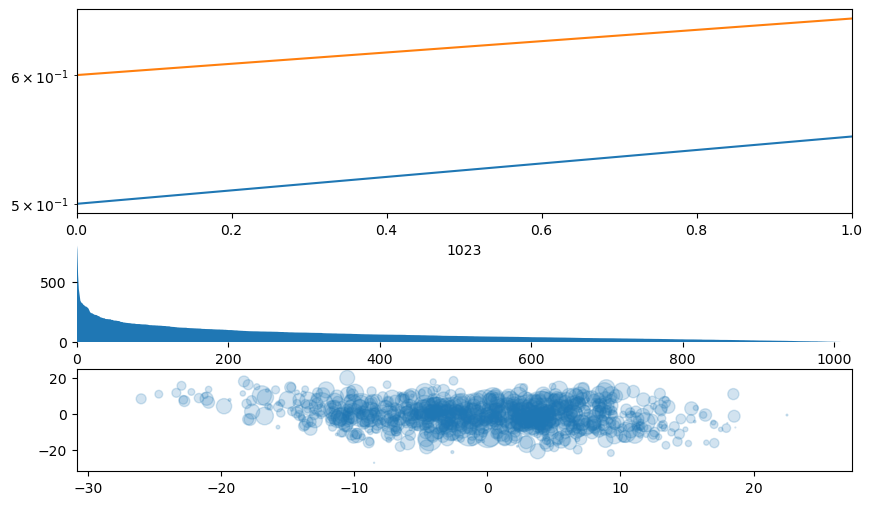

In [ ]:
# test VQVisual
visual = VQVisual(vqmodel, 1)
visual.show()
visual.add_data(0, 1e-4, 0.5, 0.6)
visual.add_data(1, 1.2e-4, 0.55, 0.65)
visual.hide()

In [ ]:
# training code
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import random
import IPython

def train(model_name, model, train, val, half=False, bs=16, lr=1e-4, visual_class = VQVisual,
          weight_decay=0.1, pct_start=0.3, warmup=5000, warmup_mul=1e-2, epochs=10,
          run_valid_every_iters=100, table_row_every_iters=1000,
          device="cuda"):
    try:
        scheduler = None
        visual = visual_class(model, epochs*len(train))
        all_params = set(model.parameters())
        wd_params = set()
        for m in model.modules():
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                wd_params.add(m.weight)
                if m.bias is not None:
                    wd_params.add(m.bias)
        no_wd_params = all_params - wd_params

        optimizer = torch.optim.AdamW(lr=lr * warmup_mul, betas=(0.9, 0.95), #fused=True,
            params=[
                {"params": list(wd_params), "weight_decay": weight_decay},
                {"params": list(no_wd_params), "weight_decay": 0.0},
            ]
        )
        scaler = torch.cuda.amp.GradScaler(enabled=half)

        train_loader = DataLoader(train, batch_size=bs, num_workers=20, drop_last=False, shuffle=True)
        val_loader = DataLoader(val, batch_size=bs, num_workers=20, drop_last=False)
        chkpt_every_iters = 5000

        it = 0
        start_t = time.time()
        next_val_it = it + 50
        next_chkpt_it = chkpt_every_iters
        next_table_it = table_row_every_iters
        
        commit_loss = torch.nan
        ce_loss = torch.nan
        kl_loss = torch.nan
        val_loss = torch.nan
        avg_train_loss = torch.nan
        
        visual.show()

        mb = master_bar(range(epochs))
        mb.write(["samples", "train", "val", "time"], table=True)
        running_loss = [0]
        for epoch in mb:
            bar = progress_bar(train_loader, parent=mb)
            for batch in bar:
                # zero the parameter gradients
                optimizer.zero_grad(set_to_none=True)

                with torch.autocast(device_type=device, dtype=torch.float16 if half else torch.float32, enabled=device!='cpu'):
                    ps, loss = model(*batch)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                if it > warmup:
                    if scheduler is None:
                        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=pct_start, steps_per_epoch=len(train_loader), epochs=epochs)
                    else:
                        scheduler.step()
                        lr = scheduler.get_last_lr()                    

                running_loss.append(loss.item())
                running_loss = running_loss[-5:]
                avg_train_loss = sum(running_loss)/len(running_loss)

                if it >= next_chkpt_it:
                    next_chkpt_it += chkpt_every_iters
                    torch.save(vqmodel.state_dict(), f'{model_name}-{it}.pt')
                    
                if it >= next_val_it:
                    next_val_it += run_valid_every_iters
                    model.eval()
                    with torch.no_grad():
                        val_loss = 0
                        commit_loss = 0
                        ce_loss = 0
                        kl_loss = 0
                        for batch in val_loader:
                            with torch.autocast(device_type=device, dtype=torch.float16 if half else torch.float32, enabled=device!='cpu'):
                                ps, loss = model(*batch)
                            val_loss += loss
                            commit_loss += model.commit_loss
                            ce_loss += model.ce_loss
                            kl_loss += model.kl_loss
                        N = len(val_loader)
                        val_loss = val_loss.item() / N; commit_loss = commit_loss.item() / N; ce_loss = ce_loss.item() / N; kl_loss = kl_loss.item() / N;
                    model.train()
                    visual.add_data(it, lr, avg_train_loss, val_loss)
                
                if it >= next_table_it:
                    elapsed_t = time.time() - start_t
                    next_table_it += table_row_every_iters
                    mb.write([it, f"{avg_train_loss:.5f}", f"{val_loss:.5f}", fastprogress.core.format_time(elapsed_t)], table=True)

                it += bs
                bar.comment = f"#{epoch+1}/{epochs} loss: {avg_train_loss:.3f} / {val_loss:.3f} commit: {commit_loss:.3f} ce: {ce_loss:.3f} kl: {kl_loss:.3f}"
    except KeyboardInterrupt:
        mb.write(f"interrupted")
        mb.show()
        pass
    finally:
        visual.hide()

In [ ]:
#| exporti
# the model
import whisper
from torch import nn
from vector_quantize_pytorch import ResidualVQ

class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)
    
def sinusoids(length, channels, max_timescale=10000):
    """Returns sinusoids for positional embedding"""
    assert channels % 2 == 0
    log_timescale_increment = np.log(max_timescale) / (channels // 2 - 1)
    inv_timescales = torch.exp(-log_timescale_increment * torch.arange(channels // 2))
    scaled_time = torch.arange(length)[:, np.newaxis] * inv_timescales[np.newaxis, :]
    return torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)

def init_transformer(m):
    if isinstance(m, (nn.Linear, nn.Embedding)):
        torch.nn.init.trunc_normal_(m.weight, std=.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        torch.nn.init.constant_(m.bias, 0)
        torch.nn.init.constant_(m.weight, 1.0)

/opt/conda/lib/python3.10/site-packages/whisper/timing.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):


In [ ]:
#| export
class RQBottleneckTransformer(nn.Module):
    def __init__(self, width=384, vq_codes=512, q_depth=12, depth=1, n_head=2,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False, kl_loss_mul=1,
                 whisper_model_name='tiny.en'):
        super().__init__()
        store_attr("codebook_dim,vq_codes,q_depth,n_head,depth,use_cosine_sim,whisper_model_name")
        
        self.kl_loss_mul = kl_loss_mul
        
        self.in_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_vq = LayerNorm(width)

        self.rq = ResidualVQ(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = 0.8,              # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
            num_quantizers= q_depth,
        )
        
        self.ce_lossf = nn.CrossEntropyLoss(ignore_index=-100)
        self.kl_lossf = nn.KLDivLoss(reduction='batchmean')

        self.register_buffer("positional_embedding", sinusoids(1500, width))
        self.register_buffer("embs_padding", None)
        
        self.out_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)
        
        self.whmodel = None
        
        self.apply(init_transformer)

    #
    # training
    #
    @torch.no_grad()
    def get_teacher_logits(self, embs, input_toks, output_toks):
        teacher_logits = whmodel.decoder(input_toks, embs)
        # set teacher logits to 0 for padding positions so KLDivLoss ignores them
        teacher_logits[output_toks == -100] = 0
        return teacher_logits
    
    def forward(self, embs, input_toks, output_toks):
        embs, input_toks, output_toks = [x.cuda() for x in [embs, input_toks, output_toks]]
        teacher_logits = self.get_teacher_logits(embs, input_toks, output_toks)
        
        # VQ bottleneck
        x = self.ln_vq(self.in_blocks(embs))
        quantized, self.indices, self.commit_loss = self.rq(x)
        self.commit_loss = self.commit_loss.mean()
        x = self.ln_post(self.out_blocks(quantized + self.positional_embedding))
        
        logits = whmodel.decoder(input_toks, x)
        self.ce_loss = self.ce_lossf(logits.view(-1,logits.shape[-1]), output_toks.view(-1))
        self.kl_loss = self.kl_lossf(F.log_softmax(logits, dim=-1), F.softmax(teacher_logits, dim=-1))
        loss = self.ce_loss + self.kl_loss_mul * self.kl_loss + self.commit_loss
        return x, loss
    
    #
    # inference
    #
    @classmethod
    def load_model(cls, repo_id="collabora/spear-tts-pytorch", filename="whisper-vq-stoks.model", local_filename=None):
        if not local_filename:
            local_filename = hf_hub_download(repo_id=repo_id, filename=filename)
        spec = torch.load(local_filename) 
        vqmodel = cls(**spec['config'])
        vqmodel.load_state_dict(spec['state_dict'])
        vqmodel.eval()
        return vqmodel
    
    def save_model(self, fname):
        torch.save(dict(config = self.__stored_args__, state_dict = self.state_dict()), fname)
        
    def ensure_whisper(self):
        assert not self.training
        if self.whmodel is None: self.whmodel = whisper.load_model(self.whisper_model_name)
        assert self.whisper_model_name.endswith('.en'), "multilingual models are not supported right now"
        self.decoding_options = whisper.DecodingOptions(language='en')
        self.tokenizer = whisper.tokenizer.get_tokenizer(False, language='en')
        silent_mel = whisper.log_mel_spectrogram(torch.zeros((1,16000*30)))
        self.embs_padding = self.whmodel.encoder(silent_mel.to(self.whmodel.device))
    
    def quantize(self, embs):
        x = self.ln_vq(self.in_blocks(embs))
        _, stoks, _ = self.rq(x)
        if self.q_depth == 1:
            stoks = stoks.squeeze(-1)
        return stoks

    def dequantize(self, stoks):
        assert self.q_depth == 1
        assert len(stoks.shape) == 1, "batch processing is not supported"
        if isinstance(stoks, np.ndarray): stoks = torch.tensor(stoks)
        # remove padding
        padding = torch.nonzero(stoks == 1024)
        if padding.any(): stoks = stoks[:padding[0,0]]
        x = self.rq.layers[0]._codebook.embed[0,stoks.to(torch.long).view(-1)]
        x = F.pad(x, (0, 0, 0, 1500-len(x)))
        x = (self.rq.layers[0].project_out(x) + self.positional_embedding).unsqueeze(0)
        return self.ln_post(self.out_blocks(x))

    def encode_audio(self, audio):
        if isinstance(audio, str):
            x, sr = torchaudio.load(audio)
            x = torchaudio.transforms.Resample(sr, 16000)(x)[0]
            audio = x.unsqueeze(0)
        return self.encode_mel(whisper.log_mel_spectrogram(audio))
    
    def encode_mel(self, mel):
        assert len(mel.shape) == 3, "invalid mel spectrogram shape, expect (batch,chn,time)"
        self.ensure_whisper()
        padded = whisper.audio.pad_or_trim(mel, whisper.audio.N_FRAMES)
        embs = self.whmodel.encoder(padded.to(self.whmodel.device))
        return self.quantize(embs)
    
    def decode_text(self, stoks, decoding_options=None):
        self.ensure_whisper()
        if decoding_options is None: decoding_options = self.decoding_options
        embs = self.dequantize(stoks).to(self.whmodel.device)
        embs = torch.cat([embs, self.embs_padding[:,embs.shape[1]:]], dim=1)
        return self.whmodel.decode(embs, decoding_options)

In [ ]:
%pdb

Automatic pdb calling has been turned OFF


samples,train,val,time
20000,413.38255,461.53012,12:25
40000,405.09925,447.97101,24:31
60000,424.49371,442.10788,36:39
80000,381.87087,429.67257,48:46
100000,272.97687,260.08321,1:00:47
120000,192.91068,168.19143,1:13:12
140000,133.61988,120.39785,1:25:23
160000,138.68134,105.93922,1:37:21
180000,132.85053,97.73884,1:49:19
200000,114.29639,88.18254,2:01:31


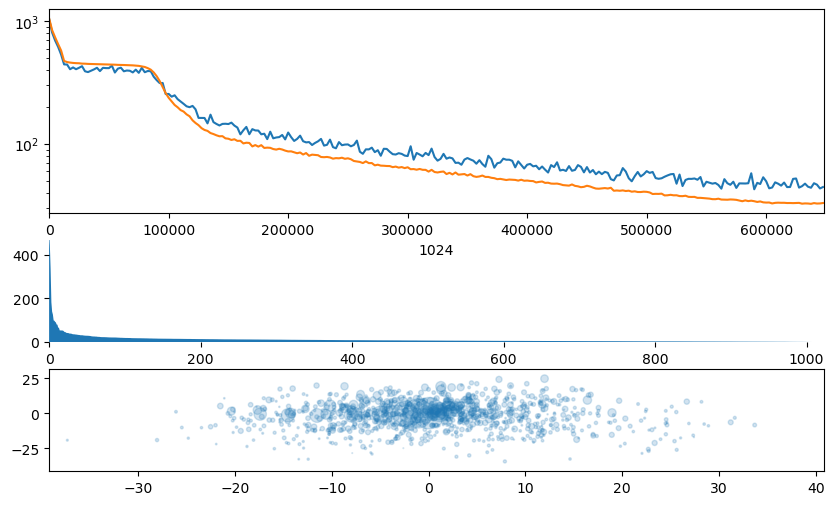

In [ ]:
# with positional embeddings, 10 bit bottleneck (1 quantizer, 1024 codes)
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=1024, q_depth=1, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1).cuda()
train("svq", vqmodel, train_ds, val_ds, bs=8, epochs=5, lr=8e-4, warmup_mul=1e-3, warmup=10000,
      run_valid_every_iters=2500, table_row_every_iters=20000)

In [ ]:
torch.save(vqmodel.state_dict(), 'vqmodel2-tiny-1000h.pth')

## Check the decoder performance with and without the RQ bottleneck

In [ ]:
embs, input_toks, _ = val_ds[0]
tokenizer.decode(whmodel.decoder(input_toks.unsqueeze(0).cuda(), embs.unsqueeze(0).cuda()).argmax(-1)[0])

' The Last Evolution by John W. Campbell Jr. This This is a Libervox recording. All All Libervox recordings are in the public domain. For more information or to volunteer, please visit the Libervox.org. Recording by Kevin Gunn. I am the last of my type existing today in all the solar system.<|endoftext|> I I I I I. I. I.... The... the. the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the) the the the the the the the the the the the the the the the the the the.... the. the..........................................'

In [ ]:
# probably a bit better with more data, good enough for now
tokenizer.decode(whmodel.decoder(input_toks.unsqueeze(0).cuda(), vqmodel(embs.unsqueeze(0).to(torch.float32), input_toks.unsqueeze(0), _.unsqueeze(0))[0]).argmax(-1)[0])

" The Last Evolution by John W. Campbell Jr. This This is a Libvox recording. All All Libervox recordings are in the public domain. For more information or to volunteer, please visit the Libervox.org. Recording by Kevin Gunn. And'm the last of my type existing today in all the solar system.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>.-<|endoftext|>.-<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|e

# Semantic token extraction
## Load the trained model

### Generate and save all semantic tokens (stoks)

In [ ]:
#| export
def load_model(fname='./vqmodel2-tiny-1000h.pth'):
    whmodel = whisper.load_model('tiny.en')
    vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=1024, q_depth=1, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1)
    vqmodel.load_state_dict(torch.load(fname))
    vqmodel.eval().cuda();
    return whmodel, vqmodel

In [ ]:
whmodel, vqmodel = load_model()

In [ ]:
#| export
from whisperspeech.extract_acoustic import load

def encode_stoks(whmodel, vqmodel, audio):
    """Encode the given `audio` (tensor or file name) into Whisper embeddings and lists of text tokens.
    Uses the given `whmodel` (see `load_model`).
    """
    if isinstance(audio, (Path, str)):
        audio = load(audio, newsr=whisper.audio.SAMPLE_RATE)
    mel = whisper.log_mel_spectrogram(audio[0,0])
    embs = []
    toks = []
    for start in range(0, mel.shape[-1], whisper.audio.N_FRAMES):
        sample = mel[:,start:]
        with torch.no_grad():
            padded = whisper.audio.pad_or_trim(sample, whisper.audio.N_FRAMES).unsqueeze(0)
            emb = whmodel.encoder(padded)
            toks.append(vqmodel.encode(emb).squeeze())
    return torch.stack(toks, axis=0)

In [ ]:
encode_stoks(whmodel, vqmodel, '/scrach/small/254/againstindifference_0801_librivox_64kb_mp3/againstindifference_webbe_add_64kb.flac').shape

torch.Size([3, 1500])

In [ ]:
#| export
@call_parse
def extract_stoks(
        srcdir:Path,  # source dir, should contain *.flac files
        outdir:Path,  # output dir, will get the *.stoks files
        model:Path,   # model path (vqmodel2-tiny-1000h.pth)
    ): 
    "Convert audio files to .stoks files quantized Whisper embeddings"
    whmodel, vqmodel = load_model(model)
        
    outdir.mkdir(exist_ok=True, parents=True)
    for name in progress_bar(list(srcdir.rglob('*.flac'))):
        stoks = encode_stoks(whmodel, vqmodel, name)
        torch.save(stoks, outdir/name.with_suffix('.stoks').name)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

# Inference example

In [ ]:
vqmodel = RQBottleneckTransformer.load_model()

In [ ]:
data = pd.read_feather(hf_hub_download('collabora/whisperspeech', 'stoks-txt/whisperspeech-librilight-stoks-txt-small-medium-A.feather', repo_type='dataset'))

In [ ]:
vqmodel.decode_text(data.iloc[0]['stoks'])[0].text, data.iloc[0]['txt_tiny']

('2. Murder in the Gunroom This is a Libra Vox recording. All Libra Vox recordings are in the public domain. For more information or to volunteer, please visit LibraVox.org. Recording by Anthony Wilson.',
 ' Preface 2. Murder in the Gunroom. This is a Libervox recording. All Libervox recordings are in the public domain. For more information or to volunteer, please visit Libervox.org. Recording by Anthony Wilson.')